# Importing Libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer,AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
from torchmetrics.classification import BinaryAccuracy,MulticlassF1Score,MulticlassPrecision,MulticlassRecall,MulticlassAccuracy,BinaryConfusionMatrix
from torchmetrics.collections import MetricCollection
import optuna
from google.colab import userdata
import neptune
import uuid
import neptune.integrations.optuna as npt_utils
import  hashlib
import time
import math
import pickle
import matplotlib.pyplot as plt

# Setting up the GPU or CPU

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [4]:
# @title Define Transformer Model Name
bert_model_name = "vinai/bertweet-base" # @param {type:"string"}

In [5]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/HatEval-Relabeled" # @param {type:"string"}



In [6]:
# @title Define Neptuna Project Name
project_name='krishanchavinda.official/Fine-Tuning-DCL-Framework'# @param {type:"string"}
neptune_id='FIN-3344'# @param {type:"string"} #if you want to start a new study keep it blank

In [7]:
# @title Define Experiment Name
study_name = "DCL_Experiments_3_v1" # @param {type:"string"}



In [8]:
dataset_tag = dataset_name
model_tag = bert_model_name

##Setting up Neptuna

In [9]:
def load_optuna_states(run:neptune.Run,directory:str):
  run[f'{directory}/optuna_storage'].download()
  run[f'{directory}/sampler'].download()
  run[f'{directory}/pruner'].download()
  run.wait()

In [10]:
if neptune_id=='':
  study_id=str(hashlib.md5(str(time.time()).encode()).hexdigest()[:8])
  sweep_id = uuid.uuid1()
  run_study_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,tags=[dataset_tag , "hyper-parameter-tuning", model_tag],name=(study_name+'_'+study_id))
  run_study_level["sweep-id"] = str(sweep_id)
  run_study_level["sys/tags"].add("study-level")
else:
  run_study_level = neptune.init_run(with_id=neptune_id,project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True)
  name=run_study_level["sys/name"].fetch()
  run_study_level.wait()
  study_name,study_id = tuple(name.rsplit('_', 1))
  sweep_id=run_study_level["sweep-id"].fetch()
  load_optuna_states(run=run_study_level,directory="optuna")

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3344


In [11]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45  # @param {type:"integer"}


# Setting Random Seed for Reproducibility

In [12]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [13]:
setup_seed(SEED)

# Loading Train,Dev Datasets

In [14]:
dataset = load_dataset(dataset_name)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Loading the Tokernizer for the Transformer Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


##Define the Tokenizer Function

In [16]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2724
    })
})

In [18]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9088 [00:00<?, ? examples/s]

Map:   0%|          | 0/1168 [00:00<?, ? examples/s]

Map:   0%|          | 0/2724 [00:00<?, ? examples/s]

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2724
    })
})

## Remove Unwanted Coloumns

In [20]:
tokenized_datasets=tokenized_datasets.remove_columns(['text'])

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2724
    })
})

## Format the coloumns

In [22]:
tokenized_datasets=tokenized_datasets.with_format("torch")

# Define the Dual Contrastive Learning Architecture



In [23]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

## Define Unsupervised Contrastive loss

In [25]:
def simcse_loss(batch_emb,temp_1:float):
    batch_size = batch_emb.size(0)
    y_true = torch.cat([torch.arange(1, batch_size, step=2, dtype=torch.long).unsqueeze(1),
                        torch.arange(0, batch_size, step=2, dtype=torch.long).unsqueeze(1)],
                       dim=1).reshape([batch_size,]).to(device)
    norm_emb = F.normalize(batch_emb, dim=1, p=2)
    sim_score = torch.matmul(norm_emb, norm_emb.transpose(0,1))
    sim_score = sim_score - (torch.eye(batch_size) * 1e12).to(device)
    sim_score = sim_score / temp_1
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(sim_score, y_true)

    return loss


## Define Supervised Contrastive loss

In [26]:
def sup_simcse_loss(batch_emb, label,temp_2:float):
    n = batch_emb.size(0)

    similarity_matrix = F.cosine_similarity(batch_emb.unsqueeze(1), batch_emb.unsqueeze(0), dim=2)
    mask = torch.ones_like(similarity_matrix) * (label.expand(n, n).eq(label.expand(n, n).t()))

    mask_no_sim = torch.ones_like(mask) - mask
    mask_dui_jiao_0 = ((torch.ones(n,n) - torch.eye(n,n)) * 1e12).to(device)
    similarity_matrix = torch.exp(similarity_matrix/temp_2)
    similarity_matrix = similarity_matrix * mask_dui_jiao_0

    sim = mask*similarity_matrix
    no_sim = similarity_matrix - sim
    no_sim_sum = torch.sum(no_sim , dim=1)
    no_sim_sum_expend = no_sim_sum.repeat(n, 1).T

    sim_sum  = sim + no_sim_sum_expend
    loss = torch.div(sim , sim_sum)
    loss = mask_no_sim + loss + (torch.eye(n, n)/1e12).to(device)
    loss = -torch.log(loss)
    loss = torch.sum(torch.sum(loss, dim=1))/(2*n)
    return loss

# Fine Tuning the Model

In [27]:
optuna_storage_location="content/optuna_storage.db"

## Format the Labels

In [28]:
def copy_label(labels):
    labels = labels.unsqueeze(1)
    labels = torch.cat((labels, labels), dim=1).reshape(-1, 1).squeeze(1)
    return labels

In [29]:
def is_supported_values(value):
  if not math.isinf(value) and not math.isnan(value):
    return True
  else:
    return False

## Define Training Loop

In [30]:
def training_loop(model, train_dataloader,optimizer,criteon,device,temp_1:float,temp_2:float,lamda:float,run_trial_level):
    accuracy_metric = BinaryAccuracy()
    accuracy_metric.to(device)
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = copy_label(batch["labels"])
        emb, pred = model(batch, if_train=True)
        loss = criteon(pred, labels.float())
        loss_sim = simcse_loss(emb,temp_1=temp_1)
        loss_supsim = sup_simcse_loss(emb, labels,temp_2=temp_2)
        total_train_loss += loss.item()

        loss_value=loss.item()
        if is_supported_values(loss_value):
          run_trial_level["train/batch/loss"].append(loss_value)
        if is_supported_values(loss_sim):
          run_trial_level["train/batch/Unsupervised_Contrastive_loss"].append(loss_sim)
        if is_supported_values(loss_supsim):
          run_trial_level["train/batch/supervised_Contrastive_loss"].append(loss_supsim)

        pred_sig = torch.sigmoid(pred)

        preds_detach=torch.round(pred_sig.detach())

        batch_level_accuracy=accuracy_metric(preds_detach,labels)

        if is_supported_values(batch_level_accuracy.item()):
          run_trial_level["train/batch/accuracy"].append(batch_level_accuracy.item())
        loss = loss + lamda*(loss_sim + loss_supsim)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    average_epoch_train_loss = total_train_loss / len(train_dataloader)  # Compute average epoch loss
    train_accuracy =  accuracy_metric.compute()
    accuracy_metric.reset()
    return average_epoch_train_loss,train_accuracy


## Define Validation Loop

In [31]:
def validation_loop(model, dev_dataloader,criteon, device,average='macro'):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_dev_loss = 0.0
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred_sig = torch.round(torch.sigmoid(pred))
        nan_exist = torch.isnan(pred_sig).any().item()
        if nan_exist:
          collection_metric.reset()
          return None
        total_dev_loss += loss.item()
        collection_metric.update(pred_sig,labels)
    average_epoch_dev_loss = total_dev_loss / len(dev_dataloader)  # Compute average epoch loss
    result = collection_metric.compute()
    result["Loss"]=average_epoch_dev_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Define Test Loop

In [32]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred = torch.round(torch.sigmoid(pred))
        total_test_loss += loss.item()
        collection_metric.update(pred, labels)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    result['Loss']= average_epoch_test_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Hyperparameter Tuning

In [33]:
storage = optuna.storages.RDBStorage("sqlite:////"+optuna_storage_location)

In [34]:
def define_model(bert_model_name:str):
    DROPOUT = 0.5
    model = DCLArchitecture(bert_model_name=bert_model_name,dropout=DROPOUT)
    model.to(device)
    return model

In [35]:
def get_data_loaders(trial,tokenized_datasets):
    BATCH_SIZE = trial.suggest_int("batch_size",100,256)
    train_dataloader=DataLoader(tokenized_datasets["train"], batch_size=BATCH_SIZE , shuffle=False)
    dev_dataloader=DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE , shuffle=False)
    test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE , shuffle=False)
    return train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE


In [36]:
def save_optuna_states():
  with open("sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)
  with open("pruner.pkl", "wb") as fout:
    pickle.dump(study.pruner, fout)

In [37]:
def upload_optuna_states(run:neptune.Run,directory:str):
    run[f"{directory}/sampler"].upload('sampler.pkl')
    run[f"{directory}/pruner"].upload('pruner.pkl')
    run[f"{directory}/optuna_storage"].upload("optuna_storage.db")
    run.wait()


In [38]:
def upload_metrics_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"]=result["BinaryAccuracy"].item()
    run[f"{directory}/Focal_Loss"]=result["Loss"]
    run[f"{directory}/Macro_Precision"]=result["MulticlassPrecision"].item()
    run[f"{directory}/Macro_Recall"]=result["MulticlassRecall"].item()
    run[f"{directory}/Macro_F1Score"]=result["MulticlassF1Score"].item()
    run[f"{directory}/ConfusionMatrix"].upload(result["BinaryConfusionMatrix"])
    run.wait()
    plt.close()

In [39]:
def upload_metrics_series_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"].append(result["BinaryAccuracy"].item())
    run[f"{directory}/Focal_Loss"].append(result["Loss"])
    run[f"{directory}/Macro_Precision"].append(result["MulticlassPrecision"].item())
    run[f"{directory}/Macro_Recall"].append(result["MulticlassRecall"].item())
    run[f"{directory}/Macro_F1Score"].append(result["MulticlassF1Score"].item())
    run.wait()

In [40]:
def objective(trial):
    # Define the hyperparameters to optimize
    setup_seed(SEED)
    EPOCHS = trial.suggest_int("epochs",1,2)
    ALPHA= 0.3 #trial.suggest_float("alpha", 0.20,0.4,log=True)
    GAMMA = 2 #trial.suggest_float("gamma", 0.1,5.0)
    TEMP_1 = 0.1 #trial.suggest_float("temp_1", 0.001,0.8,log=True)
    TEMP_2 = 0.05 #trial.suggest_float("temp_2", 0.001,0.8,log=True)
    LAMBDA = trial.suggest_float("lambda", 0.6,1.0)
    LR = trial.suggest_float("learning_rate", 1e-5 ,1e-3,log=True)
    train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE = get_data_loaders(trial=trial,tokenized_datasets=tokenized_datasets)
    model = define_model(bert_model_name=bert_model_name)
    optimizer = torch.optim.AdamW(model.parameters(),lr = LR)
    criteon = FocalLoss(ALPHA, GAMMA)
    param = {
        "EPOCHS": EPOCHS,
        "ALPHA": ALPHA,
        "GAMMA": GAMMA,
        "TEMP_1": TEMP_1,
        "TEMP_2":TEMP_2,
        "BATCH_SIZE":BATCH_SIZE,
        "LEARNING_RATE":LR,
        "DROPOUT":0.5,
        "LAMBDA":LAMBDA,
        "SEED":SEED
    }

     # Create a trial-level run
    run_trial_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,
    name=study_name+"_"+str(study_id)+"_"+str(trial.number),tags=[model_tag,dataset_tag,(study_name+'_'+study_id),str(trial.number+1)])

    # Log sweep ID to trial-level run
    run_trial_level["sys/tags"].add("trial-level")
    run_trial_level["sweep-id"] = str(sweep_id)

    # Log parameters of a trial-level run
    run_trial_level["parameters"] = param

    for epoch in range(EPOCHS):
        average_epoch_train_loss,train_accuracy = training_loop(model=model, train_dataloader=train_dataloader,optimizer=optimizer,criteon=criteon,device=device,temp_1=TEMP_1,temp_2=TEMP_2,lamda=LAMBDA,run_trial_level=run_trial_level)
        dev_result_metrics = validation_loop(model=model,dev_dataloader=dev_dataloader,criteon=criteon,device=device)

        if  dev_result_metrics==None:
              objective_value=-1
        else:
              objective_value = dev_result_metrics['MulticlassF1Score'].item()
        trial.report(objective_value, epoch)
        if trial.should_prune():
            run_trial_level["sys/tags"].add("pruned")
            run_trial_level.stop()
            raise optuna.exceptions.TrialPruned()


        run_trial_level["train/epoch/Focal_Loss"].append(average_epoch_train_loss)
        run_trial_level["train/epoch/accuracy"].append(train_accuracy.item())

        upload_metrics_series_result(directory="evaluation/epoch",result=dev_result_metrics,run=run_trial_level)

    run_trial_level["train/Focal_Loss"]=average_epoch_train_loss
    run_trial_level["train/accuracy"]=train_accuracy.item()

    upload_metrics_result(directory="evaluation",result=dev_result_metrics,run=run_trial_level)

    if dev_result_metrics!=None:
        result_metrics=test_loop(model=model, test_dataloader=test_dataloader,criteon=criteon,device=device)
        upload_metrics_result(run=run_trial_level,directory="Test_Results",result=result_metrics)

    # Stop trial-level Run
    run_trial_level.stop()
    save_optuna_states()
    upload_optuna_states(run=run_study_level,directory="optuna")
    return objective_value


In [41]:
if neptune_id=='':
    sampler = optuna.samplers.TPESampler(seed=SEED,multivariate=True,group=True,n_startup_trials=20,consider_prior=True)
    pruner=optuna.pruners.ThresholdPruner(lower=0)
else:
    sampler=pickle.load(open("sampler.pkl", "rb"))
    pruner=pickle.load(open("pruner.pkl", "rb"))

In [42]:
neptune_callback = npt_utils.NeptuneCallback(run_study_level)

In [43]:
study = optuna.create_study(study_name=study_name,storage=storage,load_if_exists=True,direction='maximize',sampler=sampler,pruner=pruner)

[I 2024-01-02 05:41:47,851] Using an existing study with name 'DCL_Experiments_3_v1' instead of creating a new one.


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3433


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3433/metadata


[I 2024-01-02 05:43:07,158] Trial 87 finished with value: 0.7934340834617615 and parameters: {'epochs': 1, 'lambda': 0.6874540315900117, 'learning_rate': 6.566046463190201e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3434


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3434/metadata


[I 2024-01-02 05:45:36,922] Trial 88 finished with value: 0.7477359771728516 and parameters: {'epochs': 2, 'lambda': 0.764762011805085, 'learning_rate': 3.1215846573342324e-05, 'batch_size': 104}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3435


  0%|          | 0/88 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3435/metadata


[I 2024-01-02 05:46:59,645] Trial 89 finished with value: 0.7324446439743042 and parameters: {'epochs': 1, 'lambda': 0.8314305374202966, 'learning_rate': 5.081973127736923e-05, 'batch_size': 104}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3436


  0%|          | 0/78 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 21 operations to synchronize with Neptune. Do not kill this process.
All 21 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3436/metadata


[I 2024-01-02 05:48:09,685] Trial 90 pruned. 


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3437


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3437/metadata


[I 2024-01-02 05:49:28,712] Trial 91 finished with value: 0.32013970613479614 and parameters: {'epochs': 1, 'lambda': 0.7414550360150436, 'learning_rate': 9.443083789370052e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3438


  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3438/metadata


[I 2024-01-02 05:50:45,798] Trial 92 finished with value: 0.6758171319961548 and parameters: {'epochs': 1, 'lambda': 0.936166948473306, 'learning_rate': 1.6752032171745677e-05, 'batch_size': 168}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3439


  0%|          | 0/49 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3439/metadata


[I 2024-01-02 05:52:02,692] Trial 93 finished with value: 0.7013257741928101 and parameters: {'epochs': 1, 'lambda': 0.8655961376014211, 'learning_rate': 5.2231121519133435e-05, 'batch_size': 186}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3440


  0%|          | 0/46 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3440/metadata


[I 2024-01-02 05:53:19,231] Trial 94 finished with value: 0.7662004828453064 and parameters: {'epochs': 1, 'lambda': 0.914380520884085, 'learning_rate': 9.100633340847309e-05, 'batch_size': 201}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3441


  0%|          | 0/51 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3441/metadata


[I 2024-01-02 05:54:37,159] Trial 95 finished with value: 0.7012147307395935 and parameters: {'epochs': 1, 'lambda': 0.9126414289885746, 'learning_rate': 0.00017285470835026948, 'batch_size': 179}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3442


  0%|          | 0/89 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3442/metadata


[I 2024-01-02 05:56:00,589] Trial 96 finished with value: 0.7430219650268555 and parameters: {'epochs': 1, 'lambda': 0.7173226077214776, 'learning_rate': 8.576343749755062e-05, 'batch_size': 103}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3443


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3443/metadata


[I 2024-01-02 05:57:19,196] Trial 97 finished with value: 0.7562904357910156 and parameters: {'epochs': 1, 'lambda': 0.6831460184521484, 'learning_rate': 4.387781163759772e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3444


  0%|          | 0/44 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3444/metadata


[I 2024-01-02 05:58:37,751] Trial 98 finished with value: 0.31735825538635254 and parameters: {'epochs': 1, 'lambda': 0.8666701643458261, 'learning_rate': 0.00015077258498537356, 'batch_size': 208}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3445


  0%|          | 0/69 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3445/metadata


[I 2024-01-02 05:59:58,397] Trial 99 finished with value: 0.6153210401535034 and parameters: {'epochs': 1, 'lambda': 0.6637371895422108, 'learning_rate': 0.00013535860112098524, 'batch_size': 132}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3446


  0%|          | 0/37 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3446/metadata


[I 2024-01-02 06:01:15,977] Trial 100 finished with value: 0.6527523398399353 and parameters: {'epochs': 1, 'lambda': 0.7789107857678438, 'learning_rate': 0.00013493519508010187, 'batch_size': 250}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3447


  0%|          | 0/63 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3447/metadata


[I 2024-01-02 06:02:35,156] Trial 101 finished with value: 0.721053957939148 and parameters: {'epochs': 1, 'lambda': 0.9482877739255371, 'learning_rate': 8.546820421059593e-05, 'batch_size': 145}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3448


  0%|          | 0/85 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3448/metadata


[I 2024-01-02 06:03:54,800] Trial 102 finished with value: 0.34602463245391846 and parameters: {'epochs': 1, 'lambda': 0.7079066554646284, 'learning_rate': 0.0002768462155471358, 'batch_size': 108}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3449


  0%|          | 0/88 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3449/metadata


[I 2024-01-02 06:05:16,418] Trial 103 finished with value: 0.34602463245391846 and parameters: {'epochs': 1, 'lambda': 0.7465810042861961, 'learning_rate': 0.00022897514503621372, 'batch_size': 104}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3450


  0%|          | 0/81 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3450/metadata


[I 2024-01-02 06:06:33,941] Trial 104 finished with value: 0.7610795497894287 and parameters: {'epochs': 1, 'lambda': 0.672444953324335, 'learning_rate': 0.00014666386100403378, 'batch_size': 113}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3451


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3451/metadata


[I 2024-01-02 06:08:53,727] Trial 105 finished with value: 0.7165927886962891 and parameters: {'epochs': 2, 'lambda': 0.705875715501124, 'learning_rate': 2.2881311357819423e-05, 'batch_size': 256}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3452


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3452/metadata


[I 2024-01-02 06:11:23,794] Trial 106 finished with value: 0.7710762619972229 and parameters: {'epochs': 2, 'lambda': 0.819948493993615, 'learning_rate': 0.00010508980244849187, 'batch_size': 135}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3453


  0%|          | 0/57 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3453/metadata


[I 2024-01-02 06:12:41,704] Trial 107 finished with value: 0.6680361032485962 and parameters: {'epochs': 1, 'lambda': 0.7485452462518968, 'learning_rate': 4.589210625925383e-05, 'batch_size': 162}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3454


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3454/metadata


[I 2024-01-02 06:15:01,700] Trial 108 finished with value: 0.7368014454841614 and parameters: {'epochs': 2, 'lambda': 0.6251540689537585, 'learning_rate': 3.9549930665138376e-05, 'batch_size': 168}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3455


  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3455/metadata


[I 2024-01-02 06:16:17,764] Trial 109 finished with value: 0.7317585349082947 and parameters: {'epochs': 1, 'lambda': 0.8052236257607194, 'learning_rate': 0.0002572276436251859, 'batch_size': 166}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3456


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3456/metadata


[I 2024-01-02 06:17:37,389] Trial 110 finished with value: 0.780564546585083 and parameters: {'epochs': 1, 'lambda': 0.6391006196544181, 'learning_rate': 9.00039964478192e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3457


  0%|          | 0/80 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3457/metadata


[I 2024-01-02 06:18:59,472] Trial 111 finished with value: 0.7217047214508057 and parameters: {'epochs': 1, 'lambda': 0.6176967393679984, 'learning_rate': 8.636776721336564e-05, 'batch_size': 115}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3458


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3458/metadata


[I 2024-01-02 06:20:18,640] Trial 112 finished with value: 0.7875117063522339 and parameters: {'epochs': 1, 'lambda': 0.6998382159379607, 'learning_rate': 9.612832452051311e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3459


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3459/metadata


[I 2024-01-02 06:21:38,797] Trial 113 finished with value: 0.789618968963623 and parameters: {'epochs': 1, 'lambda': 0.6604446931432695, 'learning_rate': 0.00014115673016455816, 'batch_size': 101}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3460


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3460/metadata


[I 2024-01-02 06:22:57,714] Trial 114 finished with value: 0.34602463245391846 and parameters: {'epochs': 1, 'lambda': 0.6592943088314899, 'learning_rate': 0.0001727716557792886, 'batch_size': 101}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3461


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3461/metadata


[I 2024-01-02 06:24:16,880] Trial 115 finished with value: 0.7905665636062622 and parameters: {'epochs': 1, 'lambda': 0.6456516859513335, 'learning_rate': 5.0033742804592466e-05, 'batch_size': 102}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3462


  0%|          | 0/42 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3462/metadata


[I 2024-01-02 06:25:35,127] Trial 116 finished with value: 0.34602463245391846 and parameters: {'epochs': 1, 'lambda': 0.8871803924722993, 'learning_rate': 0.000840626041570735, 'batch_size': 218}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3463


  0%|          | 0/81 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3463/metadata


[I 2024-01-02 06:26:52,852] Trial 117 finished with value: 0.5899962186813354 and parameters: {'epochs': 1, 'lambda': 0.6239158879231861, 'learning_rate': 3.305722691304101e-05, 'batch_size': 113}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3464


  0%|          | 0/86 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3464/metadata


[I 2024-01-02 06:28:14,689] Trial 118 finished with value: 0.32013970613479614 and parameters: {'epochs': 1, 'lambda': 0.6216331180221009, 'learning_rate': 0.00011460515341400881, 'batch_size': 106}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3465


  0%|          | 0/91 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3465/metadata


[I 2024-01-02 06:29:35,659] Trial 119 finished with value: 0.7513313889503479 and parameters: {'epochs': 1, 'lambda': 0.6242170412093466, 'learning_rate': 6.498971893191568e-05, 'batch_size': 100}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3466


  0%|          | 0/61 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3466/metadata


[I 2024-01-02 06:30:52,211] Trial 120 finished with value: 0.6788440346717834 and parameters: {'epochs': 1, 'lambda': 0.6853749586983418, 'learning_rate': 5.464801978959568e-05, 'batch_size': 150}. Best is trial 50 with value: 0.7981178760528564.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3467


  0%|          | 0/90 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3467/metadata


[I 2024-01-02 06:32:11,332] Trial 121 finished with value: 0.7667577266693115 and parameters: {'epochs': 1, 'lambda': 0.6788612444967012, 'learning_rate': 4.680958901458402e-05, 'batch_size': 101}. Best is trial 50 with value: 0.7981178760528564.


Best Value: 0.7981178760528564
Best hyperparameters: {'epochs': 1, 'lambda': 0.8841038484349059, 'learning_rate': 0.00014667204144816677, 'batch_size': 179}


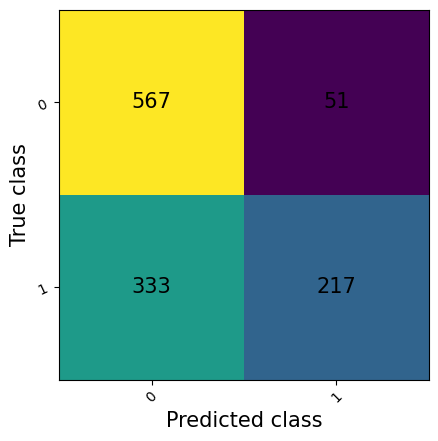

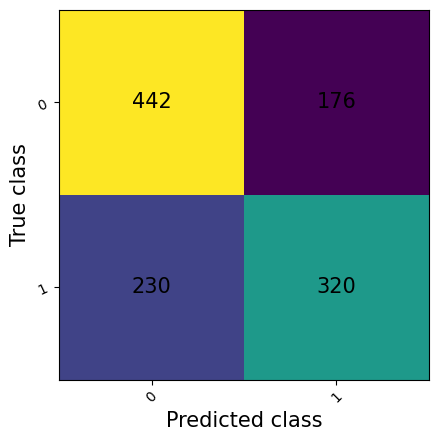

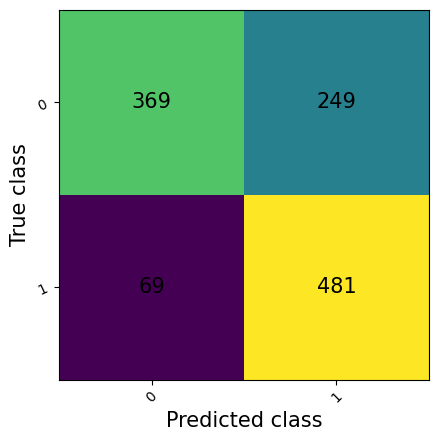

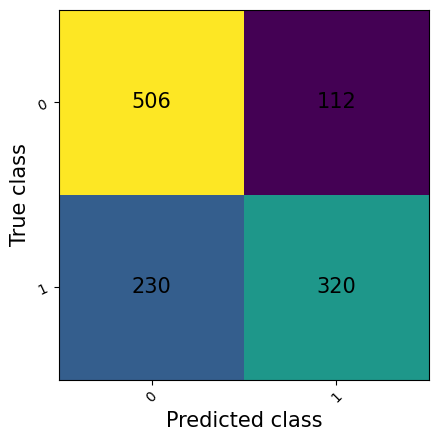

In [44]:
study.optimize(objective, n_trials=35,callbacks=[neptune_callback])

trial = study.best_trial

print('Best Value: {}'.format(trial.value))

print("Best hyperparameters: {}".format(trial.params))

In [45]:
save_optuna_states()
upload_optuna_states(run=run_study_level,directory="optuna")

In [46]:
run_study_level.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3344/metadata
